<a href="https://colab.research.google.com/github/is-leeroy-jenkins/Boo/blob/main/ipynb/models.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# TAS Analytics

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import ( LinearRegression, Ridge, RidgeClassifier, LogisticRegression,
                                   BayesianRidge, SGDRegressor, SGDClassifier  )
from sklearn.metrics import mean_squared_error, accuracy_score
from sklearn.datasets import make_classification
from sklearn.svm import SVR, SVC
from sklearn.naive_bayes import GaussianNB, BernoulliNB
from sklearn.neural_network import MLPRegressor, MLPClassifier
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, accuracy_score
from sklearn.ensemble import (RandomForestRegressor, ExtraTreesClassifier, ExtraTreesRegressor,
                            GradientBoostingClassifier, GradientBoostingRegressor, AdaBoostClassifier, AdaBoostRegressor)

from openai import OpenAI

import warnings

In [2]:
hdr = '\r\n' + '-' * 120 + '\r\n'
nwln = '\r\n'
warnings.filterwarnings( 'ignore' )

##### Balances Dataset

In [3]:
# Load the Excel file
file_path_balances = r'C:\Users\terry\Desktop\Account Balances.xlsx'
df_balances = pd.read_excel( file_path_balances, sheet_name = 'Data' )
numeric_columns = [ 'CarryoverAuthority', 'CarryoverAdjustments', 'AnnualAppropriations',
                    'BorrowingAuthority', 'ContractAuthority', 'OffsettingReceipts',
                    'Obligations', 'Recoveries', 'UnobligatedBalance', 'Outlays', 'TotalResources' ]
subset_columns = [ 'AnnualAppropriations', 'CarryoverAuthority', 'UnobligatedBalance',
                   'Obligations', 'Outlays' ]

# Filter data
all = [ 'AccountBalancesId', 'AgencyIdentifier', 'AgencyName', 'BeginningPeriodOfAvailability',
        'EndingPeriodOfAvailablity', 'Availability', 'MainAccountCode', 'SubAccountCode',
        'TreasuryAccountSymbol', 'TreasuryAccountName', 'BudgetFunction', 'BudgetSubFunction',
        'FederalAccountSymbol', 'FederalAccountName', 'LastModified',
        'SubmissionPeriod' ] + numeric_columns
subset = [ 'AgencyName', 'BudgetFunction' ] + subset_columns

# Define complete dataset
df_dataset = df_balances[ all ].fillna( 0 )
df_subset = df_balances[ subset ].fillna( 0 )

# Convert fiscal year columns to numeric
df_dataset.iloc[ :, 5: ] = df_dataset.iloc[ :, 5: ].apply( pd.to_numeric, errors = 'coerce' )

print( hdr )
print( 'Descriptive Statistics - Balances Dataset' )
print( nwln )

# Descriptive Statistics & Probability Distributions
df_descriptive = df_dataset[ numeric_columns ].describe( percentiles=[ .25, .5, .75 ] )

df_descriptive.round( 2 )


------------------------------------------------------------------------------------------------------------------------

Descriptive Statistics - Balances Dataset




,CarryoverAuthority,CarryoverAdjustments,AnnualAppropriations,BorrowingAuthority,ContractAuthority,OffsettingReceipts,Obligations,Recoveries,UnobligatedBalance,Outlays,TotalResources
count,5.698700e+04,5.698700e+04,5.698700e+04,5.698700e+04,5.698700e+04,5.698700e+04,5.698700e+04,5.698700e+04,5.698700e+04,5.698700e+04,5.698700e+04
mean,2.236022e+08,1.670400e+07,9.640120e+08,5.143275e+06,2.341911e+07,5.658304e+07,1.044334e+09,2.671504e+07,2.451300e+08,1.002847e+09,1.289464e+09
std,4.410790e+09,9.209870e+08,1.926234e+10,3.624667e+08,1.010791e+09,1.118463e+09,1.907602e+10,6.600979e+08,4.591571e+09,1.872748e+10,1.995196e+10
min,-1.243823e+10,-1.069944e+11,-4.778902e+11,0.000000e+00,-1.653946e+07,-7.315833e+09,-9.230616e+06,-1.885326e+06,-2.344574e+10,-4.726972e+06,-4.288210e+09
25%,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,4.680000e+00,7.901800e+02,9.932670e+04
50%,4.765065e+05,5.533000e+02,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.073116e+05,1.535033e+04,5.543914e+05,1.329503e+06,2.305069e+06
75%,6.926488e+06,7.500632e+05,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.115899e+07,1.024507e+06,7.935946e+06,3.053774e+07,3.612729e+07
max,4.681363e+11,1.219471e+11,1.301902e+12,4.569707e+10,1.061979e+11,1.202509e+11,1.301902e+12,7.949705e+10,4.681363e+11,1.293782e+12,1.301902e+12


In [5]:
# Select features and target for linear regression
features = df_dataset[ [ 'Obligations', 'UnobligatedBalance', 'Outlays' ] ]
target = df_dataset[ 'TotalResources' ]

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split( features, target, test_size=0.2, random_state=42 )

# Initialize and train the linear regression model
linear_regressor = LinearRegression( )
linear_regressor.fit( X_train, y_train )

# Make predictions
y_prediction = linear_regressor.predict( X_test )

# Calculate the mean squared error
mse = mean_squared_error( y_test, y_prediction )

# Display the mean squared error and a sample of predictions
mse, y_prediction[ :5 ]

(2.428218867012552e-08,
 array([3.13253392e+06, 1.35507555e+08, 1.00147819e-02, 1.05487241e+07,
        5.39437812e+06]))

####  Decision Tree Classifier


------------------------------------------------------------------------------------------------------------------------

Decision Tree Classifier




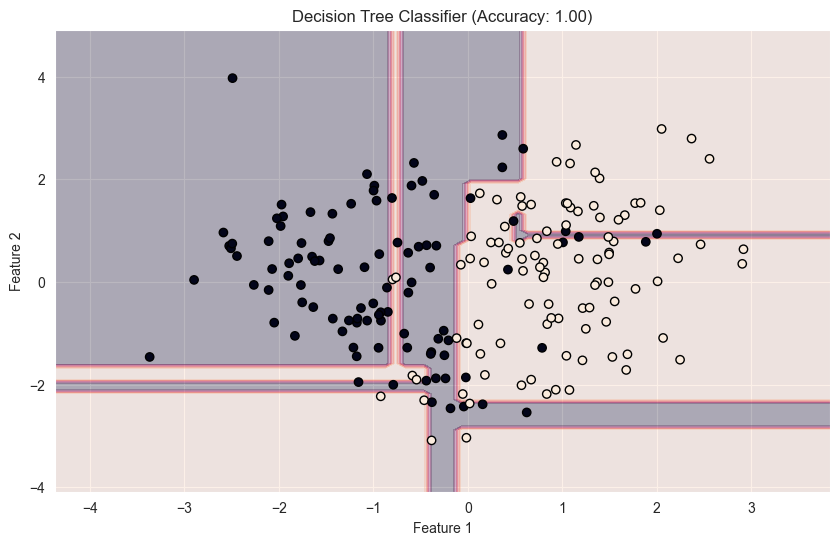

In [6]:
# Create a synthetic classification dataset
X_class, y_class = make_classification( n_samples=200, n_features=2, n_informative=2, n_redundant=0, random_state=42 )

# Train DecisionTreeClassifier
dt_classifier = DecisionTreeClassifier( random_state=42 )
dt_classifier.fit( X_class, y_class )

# Predict and evaluate
y_pred_class = dt_classifier.predict( X_class )
accuracy = accuracy_score( y_class, y_pred_class )

# Plot decision boundary
xx, yy = np.meshgrid (np.arange( X_class[ :, 0 ].min( ) - 1, X_class[ :, 0 ].max( ) + 1, 0.1 ),
                     np.arange( X_class[ :, 1 ].min( ) - 1, X_class[ :, 1 ].max( ) + 1, 0.1 ) )
Z = dt_classifier.predict( np.c_[ xx.ravel( ), yy.ravel( ) ] )
Z = Z.reshape( xx.shape )

print( hdr )
print( 'Decision Tree Classifier' )
print( nwln )

plt.figure( figsize=( 10, 6 ) )
plt.contourf( xx, yy, Z, alpha=0.3 )
plt.scatter( X_class[ :, 0 ], X_class[ :, 1 ], c=y_class, edgecolor='k', marker='o' )
plt.title( f"Decision Tree Classifier (Accuracy: {accuracy:.2f})" )
plt.xlabel( "Feature 1" )
plt.ylabel( "Feature 2" )
plt.show( )

#### Decision Tree Regressor


------------------------------------------------------------------------------------------------------------------------

Decision Tree Regressor




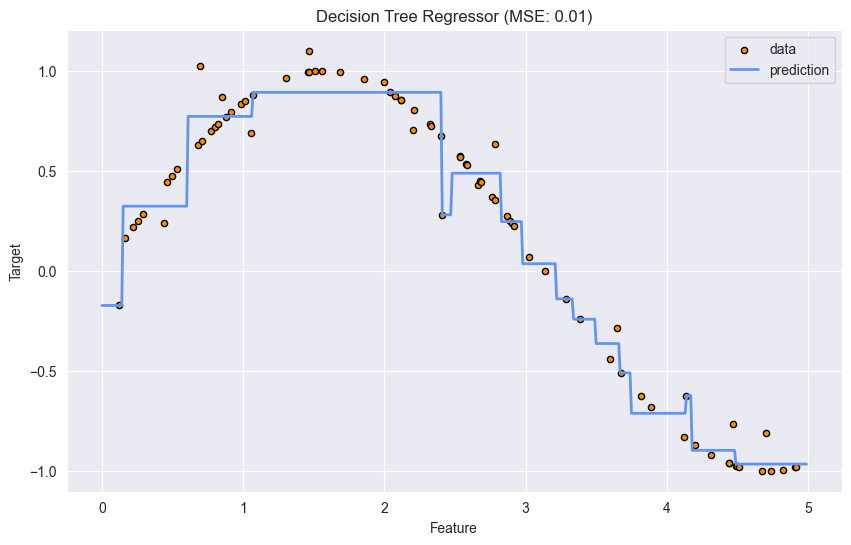

In [7]:
# Create a synthetic regression dataset
X_reg = np.sort( 5 * np.random.rand( 80, 1 ), axis=0 )
y_reg = np.sin( X_reg ).ravel( )

# Add noise to targets
y_reg[ ::5 ] += 1 * ( 0.5 - np.random.rand( 16 ) )

# Train DecisionTreeRegressor
dt_regressor = DecisionTreeRegressor( max_depth=4, random_state=42 )
dt_regressor.fit( X_reg, y_reg )

# Predict and evaluate
X_test_reg = np.arange( 0.0, 5.0, 0.01 )[ :, np.newaxis ]
y_pred_reg = dt_regressor.predict( X_test_reg )
mse = mean_squared_error( y_reg, dt_regressor.predict( X_reg ) )

print( hdr )
print( 'Decision Tree Regressor' )
print( nwln )

# Plot results
plt.figure( figsize=( 10, 6 ) )
plt.scatter( X_reg, y_reg, s=20, edgecolor="black", c="darkorange", label="data" )
plt.plot( X_test_reg, y_pred_reg, color="cornflowerblue", label="prediction", linewidth=2 )
plt.xlabel( "Feature" )
plt.ylabel( "Target" )
plt.title( f"Decision Tree Regressor (MSE: {mse:.2f})" )
plt.legend( )
plt.show( )

#### Random Forest Regressor


------------------------------------------------------------------------------------------------------------------------

Regression




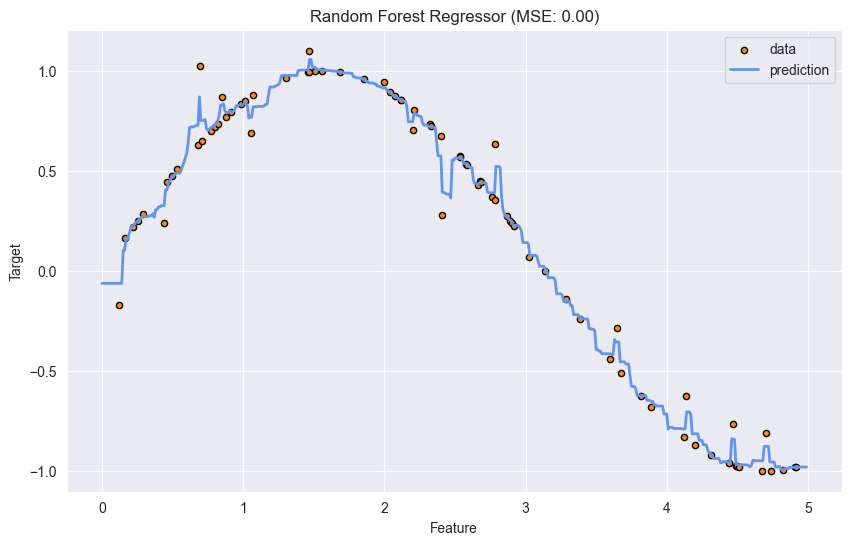

In [8]:
# Train RandomForestRegressor
rf_regressor = RandomForestRegressor( n_estimators=100, random_state=42 )
rf_regressor.fit( X_reg, y_reg )

# Predict and evaluate
y_pred_rf_reg = rf_regressor.predict( X_test_reg )
mse_rf = mean_squared_error( y_reg, rf_regressor.predict( X_reg ) )

print( hdr )
print( 'Regression' )
print( nwln )

# Plot results
plt.figure( figsize=( 10, 6 ) )
plt.scatter( X_reg, y_reg, s=20, edgecolor="black", c="darkorange", label="data" )
plt.plot( X_test_reg, y_pred_rf_reg, color="cornflowerblue", label="prediction", linewidth=2 )
plt.xlabel( "Feature" )
plt.ylabel( "Target" )
plt.title( f"Random Forest Regressor (MSE: {mse_rf:.2f})" )
plt.legend( )
plt.show( )

#### Extra Trees Classifier


------------------------------------------------------------------------------------------------------------------------

Classifier




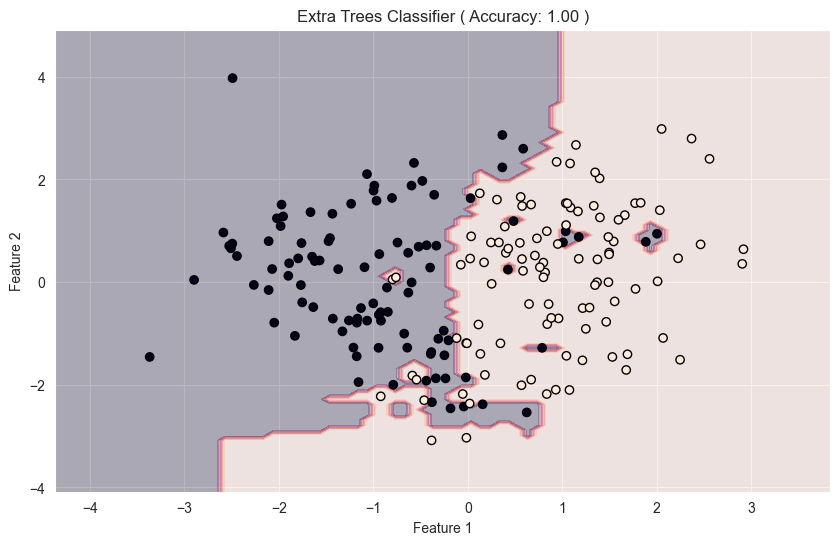

In [9]:
# Train ExtraTreesClassifier
et_classifier = ExtraTreesClassifier(n_estimators=100, random_state=42)
et_classifier.fit(X_class, y_class)

# Predict and evaluate
y_pred_et_class = et_classifier.predict(X_class)
accuracy_et = accuracy_score(y_class, y_pred_et_class)

# Plot decision boundary
Z_et = et_classifier.predict(np.c_[xx.ravel(), yy.ravel()])
Z_et = Z_et.reshape(xx.shape)

print( hdr )
print( 'Classifier' )
print( nwln )

plt.figure( figsize=( 10, 6 ) )
plt.contourf(xx, yy, Z_et, alpha=0.3)
plt.scatter(X_class[:, 0], X_class[:, 1], c=y_class, edgecolor='k', marker='o')
plt.title(f"Extra Trees Classifier ( Accuracy: {accuracy_et:.2f} )")
plt.xlabel("Feature 1")
plt.ylabel("Feature 2")
plt.show()

#### Extra Trees Regressor


------------------------------------------------------------------------------------------------------------------------

Regression




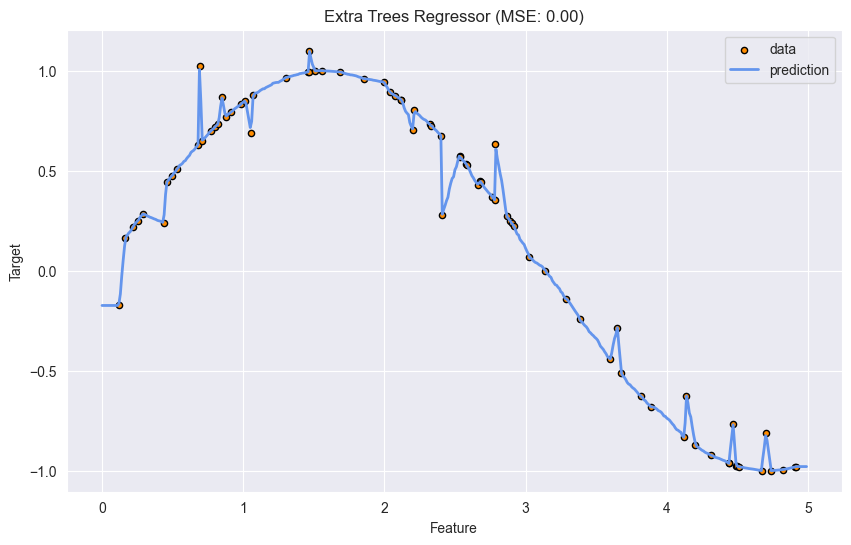

In [10]:
# Train ExtraTreesRegressor
et_regressor = ExtraTreesRegressor(n_estimators=100, random_state=42)
et_regressor.fit(X_reg, y_reg)

# Predict and evaluate
y_pred_et_reg = et_regressor.predict(X_test_reg)
mse_et = mean_squared_error(y_reg, et_regressor.predict(X_reg))

print( hdr )
print( 'Regression' )
print( nwln )

# Plot results
plt.figure( figsize=( 10, 6 ) )
plt.scatter(X_reg, y_reg, s=20, edgecolor="black", c="darkorange", label="data")
plt.plot(X_test_reg, y_pred_et_reg, color="cornflowerblue", label="prediction", linewidth=2)
plt.xlabel("Feature")
plt.ylabel("Target")
plt.title(f"Extra Trees Regressor (MSE: {mse_et:.2f})")
plt.legend()
plt.show()

#### Gradient Boosting Classifier


------------------------------------------------------------------------------------------------------------------------

Classifier




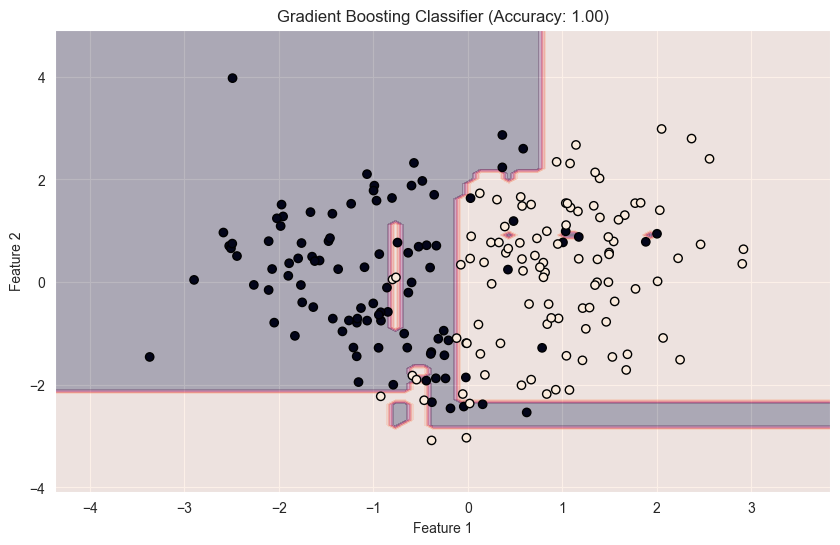

In [11]:
# Train GradientBoostingClassifier
gb_classifier = GradientBoostingClassifier(n_estimators=100, random_state=42)
gb_classifier.fit(X_class, y_class)

# Predict and evaluate
y_pred_gb_class = gb_classifier.predict(X_class)
accuracy_gb = accuracy_score(y_class, y_pred_gb_class)

# Plot decision boundary
Z_gb = gb_classifier.predict(np.c_[xx.ravel(), yy.ravel()])
Z_gb = Z_gb.reshape(xx.shape)

print( hdr )
print( 'Classifier' )
print( nwln )

# Plot results
plt.figure( figsize=( 10, 6 ) )
plt.contourf(xx, yy, Z_gb, alpha=0.3)
plt.scatter(X_class[:, 0], X_class[:, 1], c=y_class, edgecolor='k', marker='o')
plt.title(f"Gradient Boosting Classifier (Accuracy: {accuracy_gb:.2f})")
plt.xlabel("Feature 1")
plt.ylabel("Feature 2")
plt.show()

#### Gradient Boosting Regressor


------------------------------------------------------------------------------------------------------------------------

Regression




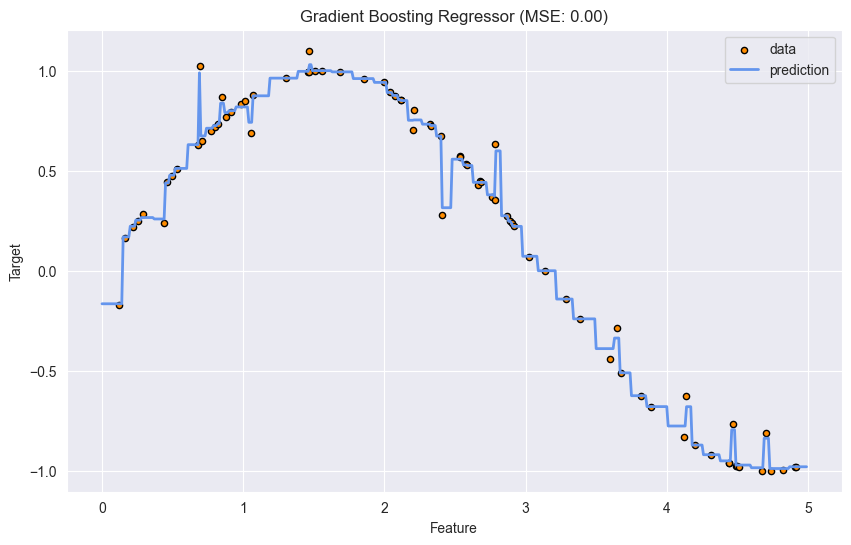

In [12]:
# Train GradientBoostingRegressor
gb_regressor = GradientBoostingRegressor(n_estimators=100, random_state=42)
gb_regressor.fit(X_reg, y_reg)

# Predict and evaluate
y_pred_gb_reg = gb_regressor.predict(X_test_reg)
mse_gb = mean_squared_error(y_reg, gb_regressor.predict(X_reg))

print( hdr )
print( 'Regression' )
print( nwln )

# Plot results
plt.figure( figsize=( 10, 6 ) )
plt.scatter(X_reg, y_reg, s=20, edgecolor="black", c="darkorange", label="data")
plt.plot(X_test_reg, y_pred_gb_reg, color="cornflowerblue", label="prediction", linewidth=2)
plt.xlabel("Feature")
plt.ylabel("Target")
plt.title(f"Gradient Boosting Regressor (MSE: {mse_gb:.2f})")
plt.legend()
plt.show()

#### Ada Boost Classifier


------------------------------------------------------------------------------------------------------------------------

Classifier




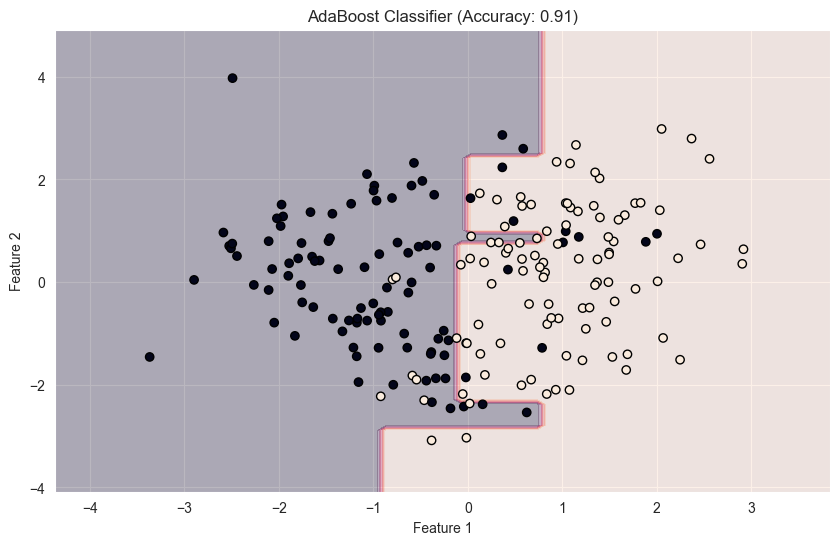

In [13]:
# Train AdaBoostClassifier
ab_classifier = AdaBoostClassifier(n_estimators=100, random_state=42)
ab_classifier.fit(X_class, y_class)

# Predict and evaluate
y_pred_ab_class = ab_classifier.predict(X_class)
accuracy_ab = accuracy_score(y_class, y_pred_ab_class)

# Plot decision boundary
Z_ab = ab_classifier.predict(np.c_[xx.ravel(), yy.ravel()])
Z_ab = Z_ab.reshape(xx.shape)

print( hdr )
print( 'Classifier' )
print( nwln )

# Plot results
plt.figure( figsize=( 10, 6 ) )
plt.contourf(xx, yy, Z_ab, alpha=0.3)
plt.scatter(X_class[:, 0], X_class[:, 1], c=y_class, edgecolor='k', marker='o')
plt.title(f"AdaBoost Classifier (Accuracy: {accuracy_ab:.2f})")
plt.xlabel("Feature 1")
plt.ylabel("Feature 2")
plt.show()

#### Ada Boost Regressor


------------------------------------------------------------------------------------------------------------------------

Regression




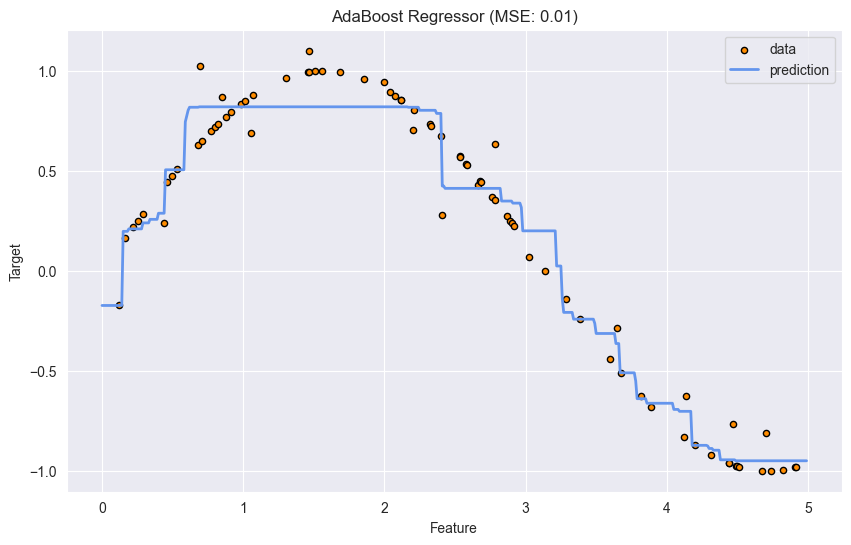

In [17]:
# Train AdaBoostRegressor
ab_regressor = AdaBoostRegressor(n_estimators=100, random_state=42)
ab_regressor.fit(X_reg, y_reg)

# Predict and evaluate
y_pred_ab_reg = ab_regressor.predict(X_test_reg)
mse_ab = mean_squared_error(y_reg, ab_regressor.predict(X_reg))

print( hdr )
print( 'Regression' )
print( nwln )

# Plot results
plt.figure( figsize=( 10, 6 ) )
plt.scatter(X_reg, y_reg, s=20, edgecolor="black", c="darkorange", label="data")
plt.plot(X_test_reg, y_pred_ab_reg, color="cornflowerblue", label="prediction", linewidth=2)
plt.xlabel("Feature")
plt.ylabel("Target")
plt.title(f"AdaBoost Regressor (MSE: {mse_ab:.2f})")
plt.legend()
plt.show()

#### Linear Regression


------------------------------------------------------------------------------------------------------------------------

Regression




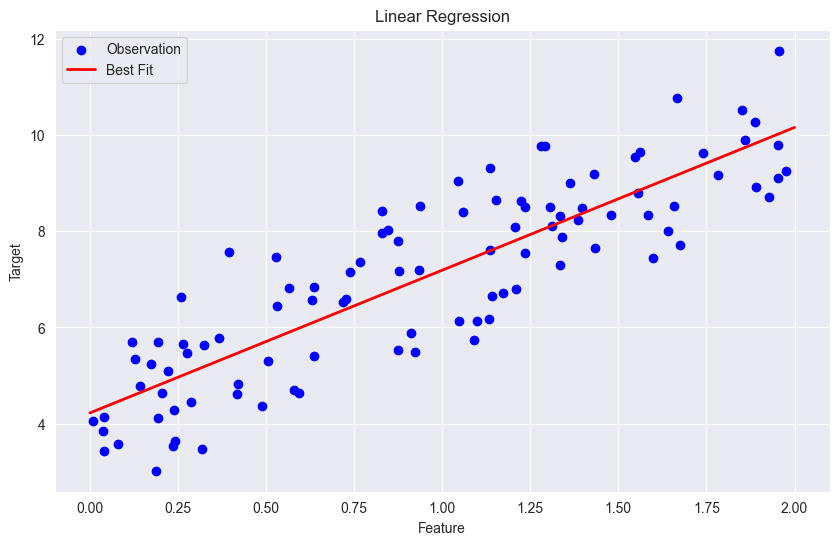

In [16]:
# Generate a synthetic regression dataset
np.random.seed(0)
X = 2 * np.random.rand(100, 1)
y = 4 + 3 * X + np.random.randn(100, 1)

# Train Linear Regression
lin_reg = LinearRegression()
lin_reg.fit(X, y)

# Predict
X_new = np.array([[0], [2]])
y_prediction = lin_reg.predict(X_new )

print( hdr )
print( 'Regression' )
print( nwln )

# Plot results
plt.figure( figsize=( 10, 6 ) )
plt.scatter(X, y, color='blue', label='Observation')
plt.plot(X_new, y_prediction, color='red', linewidth=2, label='Best Fit' )
plt.xlabel("Feature")
plt.ylabel("Target")
plt.title("Linear Regression")
plt.legend()
plt.show()

#### Ridge Classifier


------------------------------------------------------------------------------------------------------------------------

Classifier




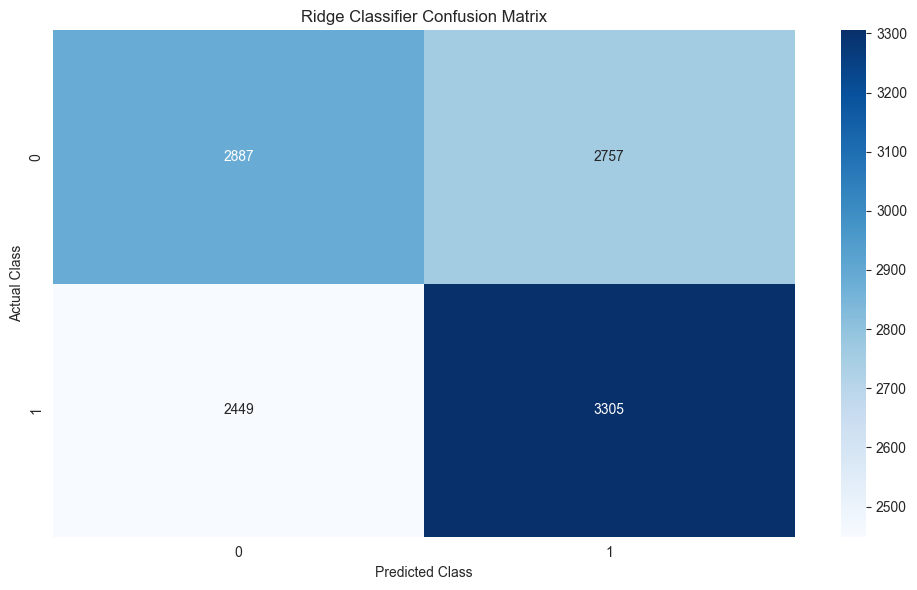

In [18]:
import pandas as pd
from sklearn.linear_model import Ridge, RidgeClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns

# Load the Excel file
file_path =  r'C:\Users\terry\Desktop\Account Balances.xlsx'
xls = pd.ExcelFile(file_path)

# Display sheet names to choose appropriate one
sheet_names = xls.sheet_names

# Load data from the first sheet for this example
df = xls.parse(sheet_names[0])

# Drop rows or columns with excessive NaNs and remove non-numeric columns for modeling
df = df.dropna()
numeric_df = df.select_dtypes(include=['float64', 'int64'])

# Ensure there are at least two columns for modeling
if numeric_df.shape[1] < 2:
    raise ValueError("Not enough numeric columns for modeling.")

# Prepare data for regression and classification
X = numeric_df.iloc[:, 1:]
y_reg = numeric_df.iloc[:, 0]
y_class = (y_reg > y_reg.median()).astype(int)

# Standardize features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Split data
X_train, X_test, y_train_reg, y_test_reg = train_test_split(X_scaled, y_reg, test_size=0.2, random_state=42)
_, _, y_train_class, y_test_class = train_test_split(X_scaled, y_class, test_size=0.2, random_state=42)

# Ridge Classifier
ridge_clf = RidgeClassifier(alpha=1.0)
ridge_clf.fit(X_train, y_train_class)
y_pred_class = ridge_clf.predict(X_test)

print( hdr )
print( 'Classifier' )
print( nwln )

# Plot Ridge Classifier
plt.figure(figsize=(10, 6))
sns.heatmap(pd.crosstab(y_test_class, y_pred_class), annot=True, fmt="d", cmap="Blues")
plt.xlabel("Predicted Class")
plt.ylabel("Actual Class")
plt.title("Ridge Classifier Confusion Matrix")
plt.tight_layout()
plt.show()



#### Ridge Regression


------------------------------------------------------------------------------------------------------------------------

Regression




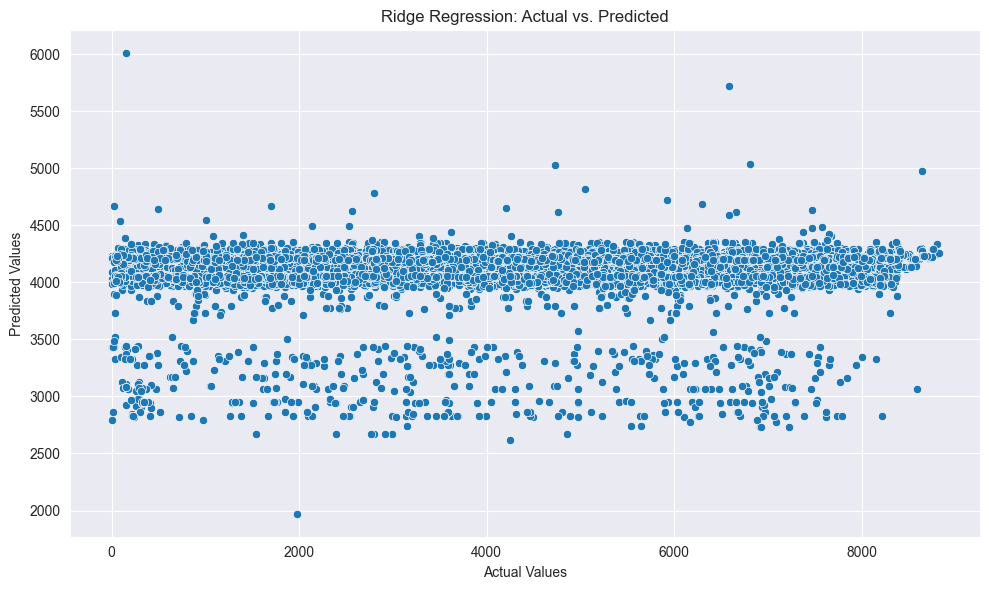

In [19]:
import pandas as pd
from sklearn.linear_model import Ridge, RidgeClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns

# Load the Excel file
file_path =  r'C:\Users\terry\Desktop\Account Balances.xlsx'
xls = pd.ExcelFile(file_path)

# Display sheet names to choose appropriate one
sheet_names = xls.sheet_names

# Load data from the first sheet for this example
df = xls.parse(sheet_names[0])

# Drop rows or columns with excessive NaNs and remove non-numeric columns for modeling
df = df.dropna()
numeric_df = df.select_dtypes(include=['float64', 'int64'])

# Ensure there are at least two columns for modeling
if numeric_df.shape[1] < 2:
    raise ValueError("Not enough numeric columns for modeling.")

# Prepare data for regression and classification
X = numeric_df.iloc[:, 1:]
y_reg = numeric_df.iloc[:, 0]
y_class = (y_reg > y_reg.median()).astype(int)

# Standardize features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Split data
X_train, X_test, y_train_reg, y_test_reg = train_test_split(X_scaled, y_reg, test_size=0.2, random_state=42)
_, _, y_train_class, y_test_class = train_test_split(X_scaled, y_class, test_size=0.2, random_state=42)

# Ridge Regression
ridge_reg = Ridge(alpha=1.0)
ridge_reg.fit(X_train, y_train_reg)
y_pred_reg = ridge_reg.predict(X_test)


print( hdr )
print( 'Regression' )
print( nwln )

# Plot Ridge Regression
plt.figure(figsize=(10, 6))
sns.scatterplot(x=y_test_reg, y=y_pred_reg)
plt.xlabel("Actual Values")
plt.ylabel("Predicted Values")
plt.title("Ridge Regression: Actual vs. Predicted")
plt.grid(True)
plt.tight_layout()
plt.show()



------------------------------------------------------------------------------------------------------------------------





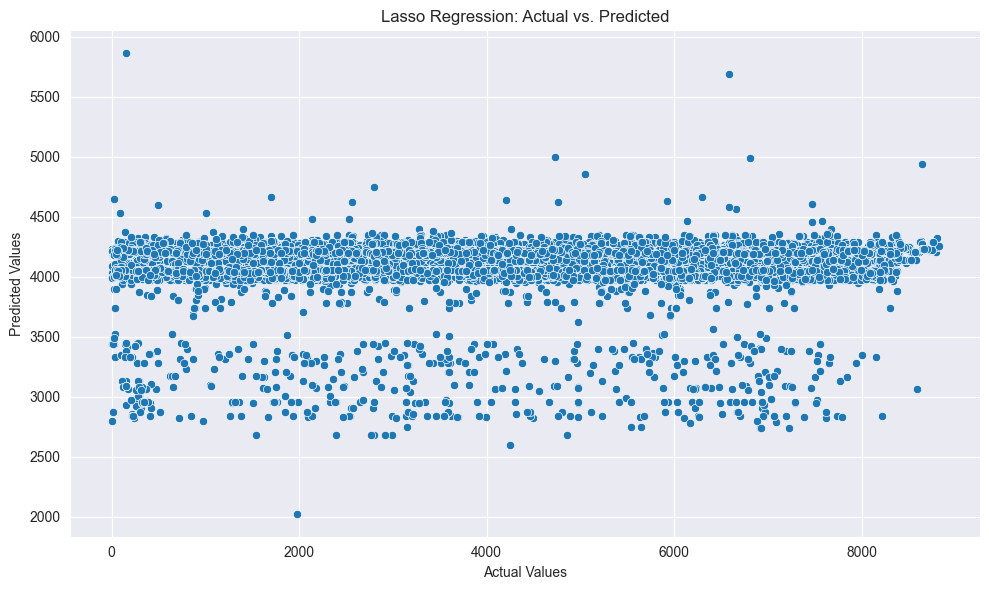


------------------------------------------------------------------------------------------------------------------------





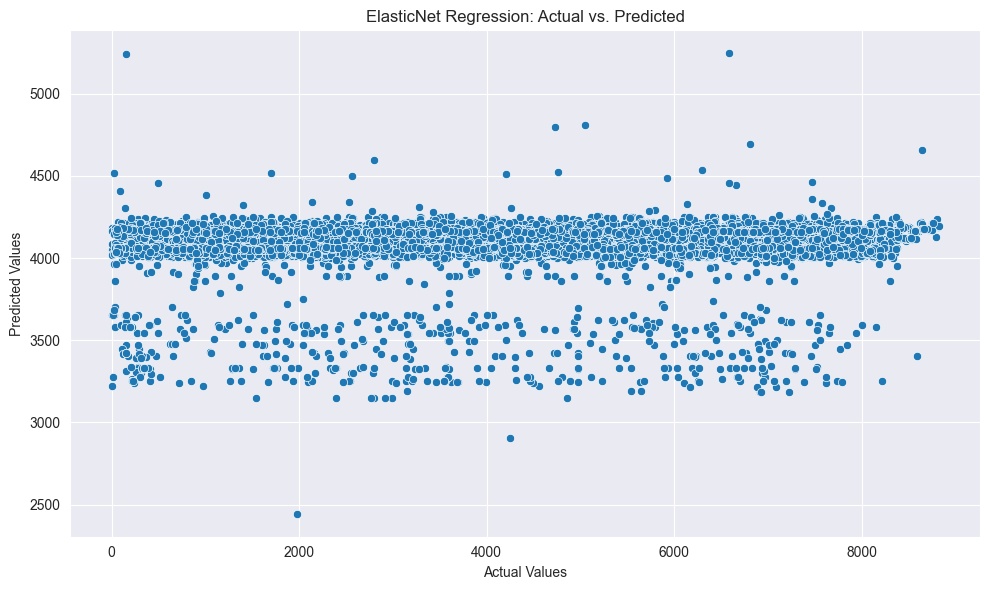


------------------------------------------------------------------------------------------------------------------------





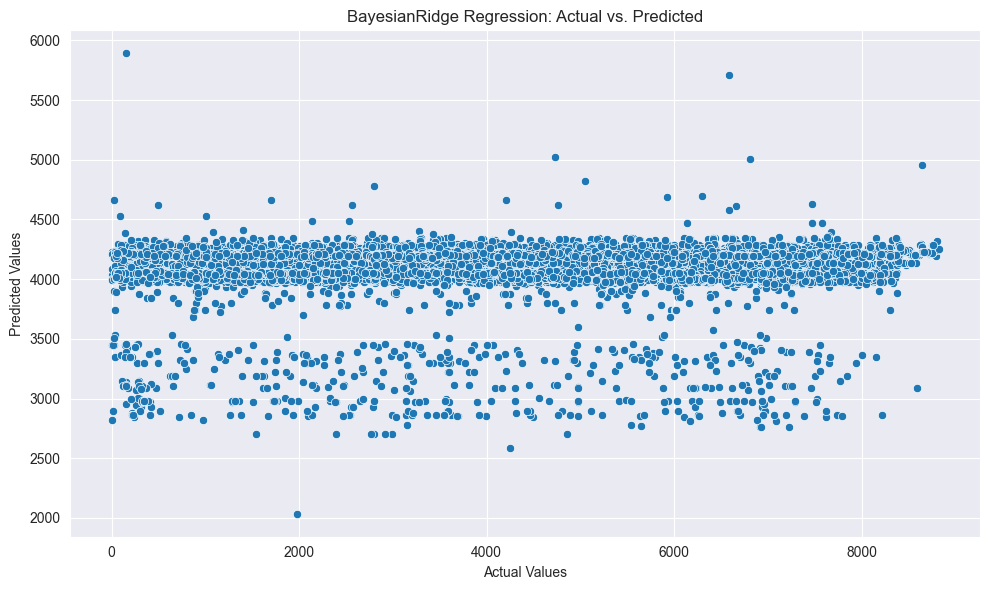


------------------------------------------------------------------------------------------------------------------------





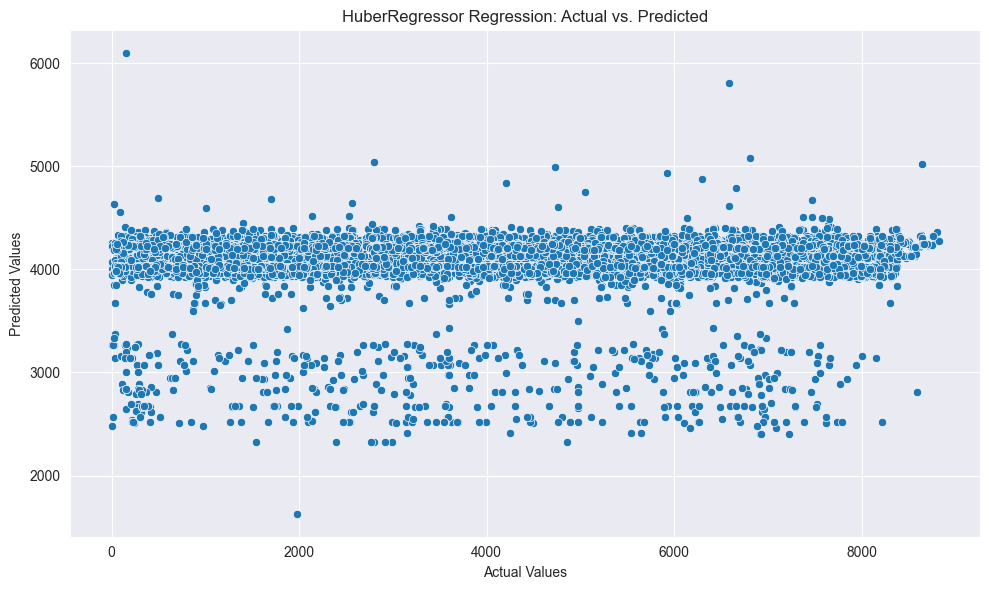

In [20]:
from sklearn.linear_model import Lasso, ElasticNet, BayesianRidge, HuberRegressor

# Initialize models
models = {
    "Lasso": Lasso(alpha=1.0, max_iter=10000),
    "ElasticNet": ElasticNet(alpha=1.0, l1_ratio=0.5, max_iter=10000),
    "BayesianRidge": BayesianRidge(),
    "HuberRegressor": HuberRegressor(max_iter=1000)
}

# Set up a plot for each model
for name, model in models.items():
    model.fit(X_train, y_train_reg)
    y_pred = model.predict(X_test)
    print( hdr )
    print( nwln )
    plt.figure(figsize=(10, 6))
    sns.scatterplot(x=y_test_reg, y=y_pred)
    plt.xlabel("Actual Values")
    plt.ylabel("Predicted Values")
    plt.title(f"{name} Regression: Actual vs. Predicted")
    plt.grid(True)
    plt.tight_layout()
    plt.show()


### SGD Classifier


------------------------------------------------------------------------------------------------------------------------

Classifier




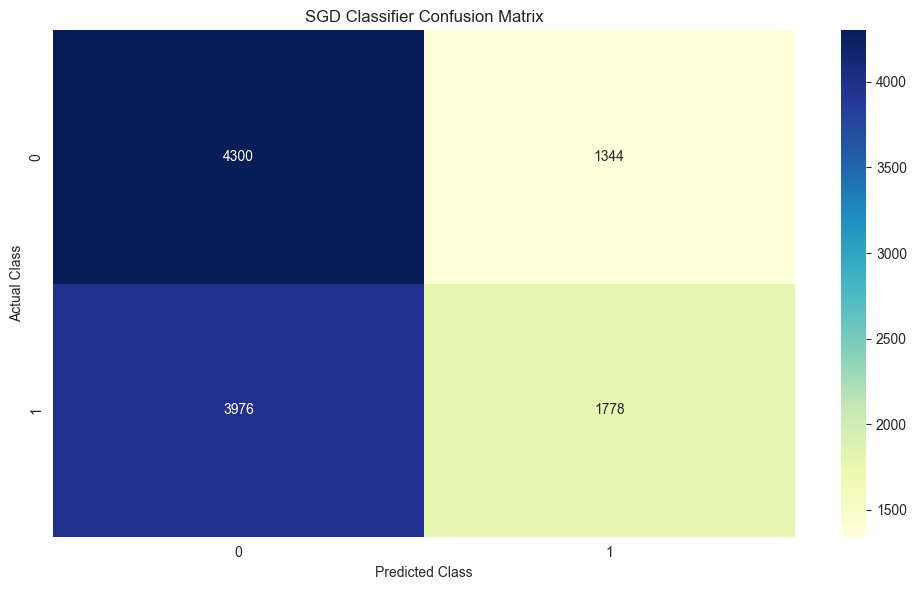

In [21]:
# SGD Classifier

print( hdr )
print( 'Classifier' )
print( nwln )

sgd_clf = SGDClassifier(max_iter=1000, tol=1e-3)
sgd_clf.fit(X_train, y_train_class)
y_pred_sgd_clf = sgd_clf.predict(X_test)

# Plot SGD Classifier
plt.figure(figsize=(10, 6))
sns.heatmap(pd.crosstab(y_test_class, y_pred_sgd_clf), annot=True, fmt="d", cmap="YlGnBu")
plt.xlabel("Predicted Class")
plt.ylabel("Actual Class")
plt.title("SGD Classifier Confusion Matrix")
plt.tight_layout()
plt.show()

### SGD Regressor


------------------------------------------------------------------------------------------------------------------------

Regression




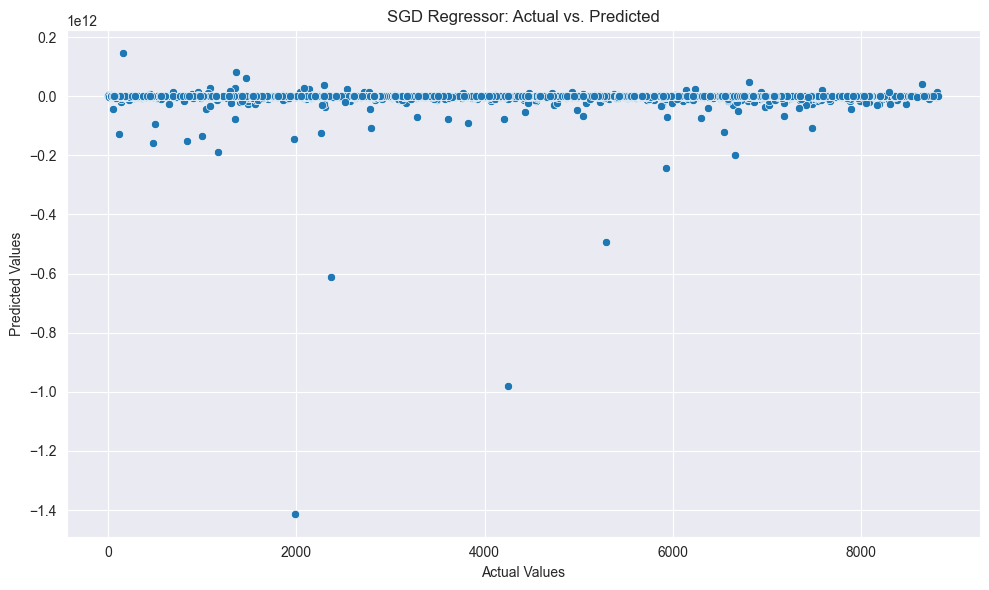

In [22]:
# SGD Regressor

print( hdr )
print( 'Regression' )
print( nwln )

sgd_reg = SGDRegressor(max_iter=1000, tol=1e-3)
sgd_reg.fit(X_train, y_train_reg)
y_pred_sgd_reg = sgd_reg.predict(X_test)


# Plot SGD Regressor
plt.figure(figsize=(10, 6))
sns.scatterplot(x=y_test_reg, y=y_pred_sgd_reg)
plt.xlabel("Actual Values")
plt.ylabel("Predicted Values")
plt.title("SGD Regressor: Actual vs. Predicted")
plt.grid(True)
plt.tight_layout()
plt.show()

### HistGradient Boosting Classifier


------------------------------------------------------------------------------------------------------------------------

Classifier




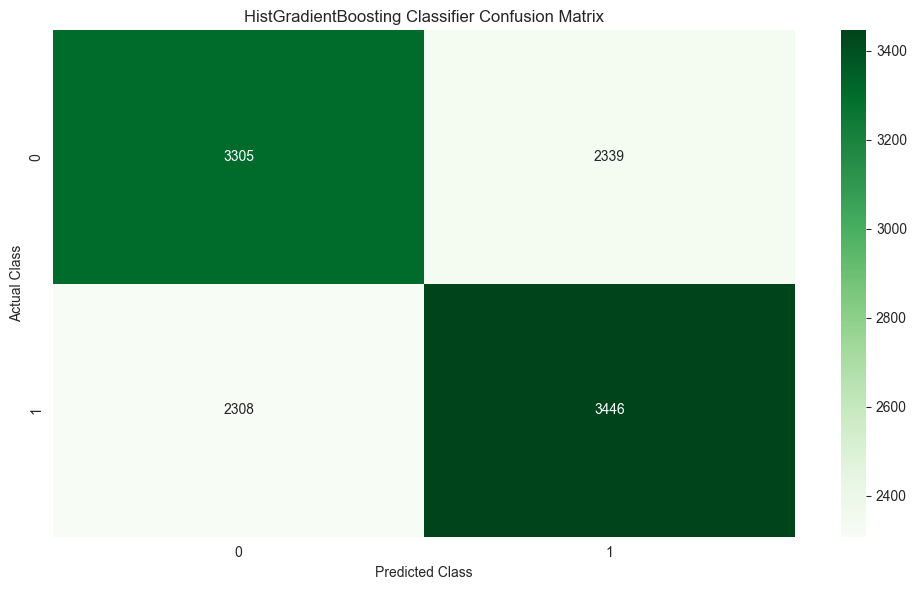

In [24]:
from sklearn.ensemble import HistGradientBoostingRegressor, HistGradientBoostingClassifier

# HistGradientBoosting Classifier
hgb_clf = HistGradientBoostingClassifier(max_iter=100)
hgb_clf.fit(X_train, y_train_class)
y_pred_hgb_clf = hgb_clf.predict(X_test)

print( hdr )
print( 'Classifier' )
print( nwln )

# Plot HistGradientBoosting Classifier
plt.figure(figsize=(10, 6))
sns.heatmap(pd.crosstab(y_test_class, y_pred_hgb_clf), annot=True, fmt="d", cmap="Greens")
plt.xlabel("Predicted Class")
plt.ylabel("Actual Class")
plt.title("HistGradientBoosting Classifier Confusion Matrix")
plt.tight_layout()
plt.show()


### HistGradient Boosting Regression


------------------------------------------------------------------------------------------------------------------------

Regression




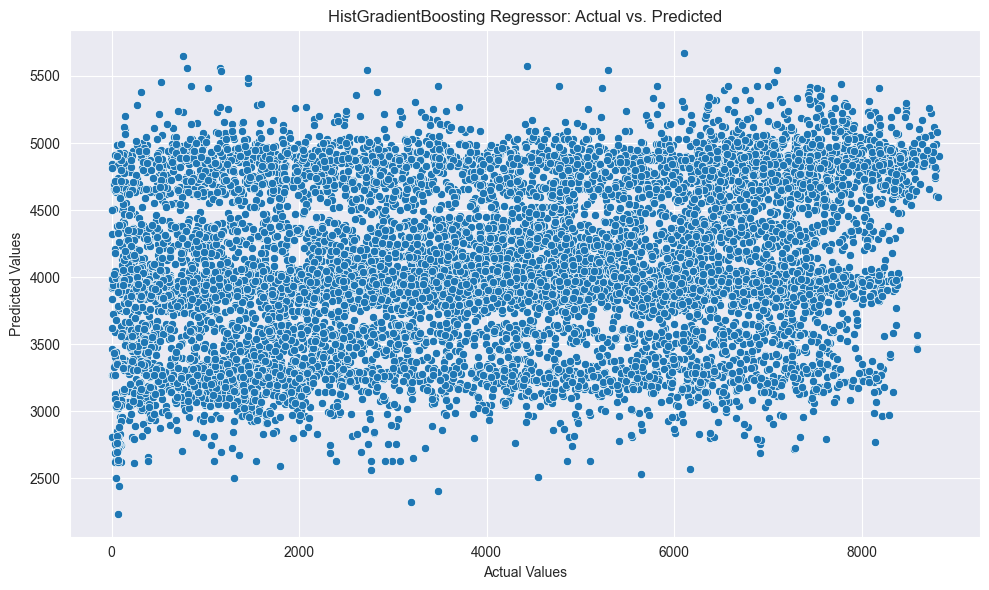

In [25]:
# HistGradientBoosting Regressor
hgb_reg = HistGradientBoostingRegressor(max_iter=100)
hgb_reg.fit(X_train, y_train_reg)
y_pred_hgb_reg = hgb_reg.predict(X_test)

print( hdr )
print( 'Regression' )
print( nwln )

# Plot HistGradientBoosting Regressor
plt.figure(figsize=(10, 6))
sns.scatterplot(x=y_test_reg, y=y_pred_hgb_reg)
plt.xlabel("Actual Values")
plt.ylabel("Predicted Values")
plt.title("HistGradientBoosting Regressor: Actual vs. Predicted")
plt.grid(True)
plt.tight_layout()
plt.show()

### KNeighborsClassifier


------------------------------------------------------------------------------------------------------------------------

Classifier




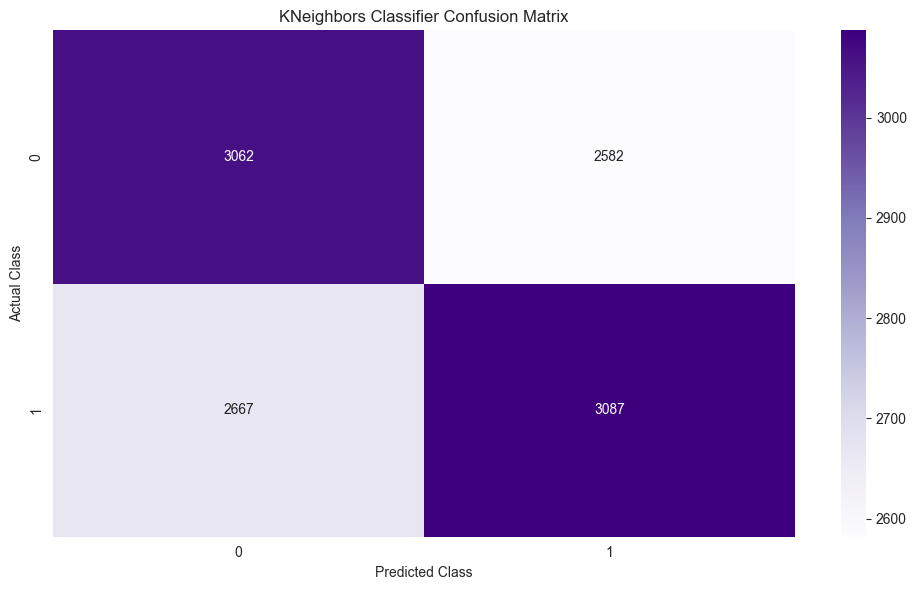

In [26]:
from sklearn.neighbors import KNeighborsRegressor, KNeighborsClassifier

# K-Nearest Neighbors Classifier
knn_clf = KNeighborsClassifier(n_neighbors=5)
knn_clf.fit(X_train, y_train_class)
y_pred_knn_clf = knn_clf.predict(X_test)

print( hdr )
print( 'Classifier' )
print( nwln )

# Plot KNN Classifier
plt.figure(figsize=(10, 6))
sns.heatmap(pd.crosstab(y_test_class, y_pred_knn_clf), annot=True, fmt="d", cmap="Purples")
plt.xlabel("Predicted Class")
plt.ylabel("Actual Class")
plt.title("KNeighbors Classifier Confusion Matrix")
plt.tight_layout()
plt.show()


### KNeighborsRegressor


------------------------------------------------------------------------------------------------------------------------

Regression




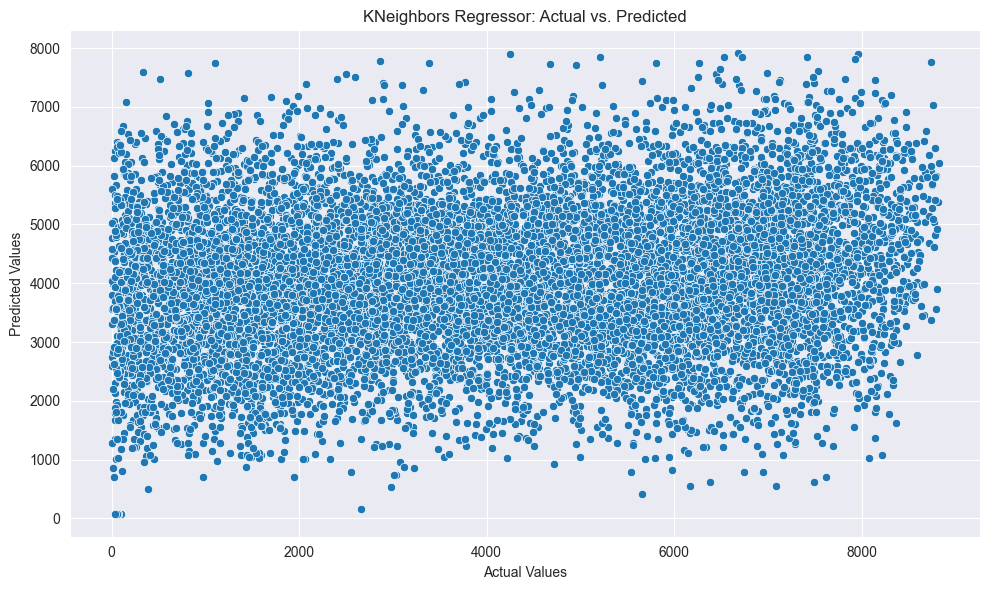

In [27]:
# K-Nearest Neighbors Regressor
knn_reg = KNeighborsRegressor(n_neighbors=5)
knn_reg.fit(X_train, y_train_reg)
y_pred_knn_reg = knn_reg.predict(X_test)


print( hdr )
print( 'Regression' )
print( nwln )

# Plot KNN Regressor
plt.figure(figsize=(10, 6))
sns.scatterplot(x=y_test_reg, y=y_pred_knn_reg)
plt.xlabel("Actual Values")
plt.ylabel("Predicted Values")
plt.title("KNeighbors Regressor: Actual vs. Predicted")
plt.grid(True)
plt.tight_layout()
plt.show()


### SVC (Support Vector Classifier)


------------------------------------------------------------------------------------------------------------------------

Classifier




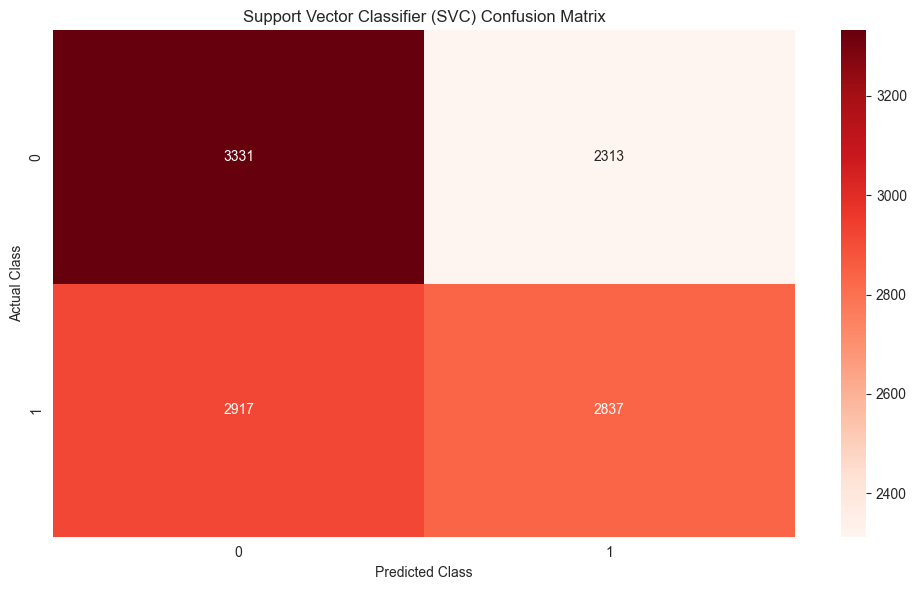

In [28]:
# Support Vector Classifier
svc_model = SVC(kernel='rbf')
svc_model.fit(X_train, y_train_class)
y_pred_svc = svc_model.predict(X_test)

print( hdr )
print( 'Classifier' )
print( nwln )


# Plot SVC
plt.figure(figsize=(10, 6))
sns.heatmap(pd.crosstab(y_test_class, y_pred_svc), annot=True, fmt="d", cmap="Reds")
plt.xlabel("Predicted Class")
plt.ylabel("Actual Class")
plt.title("Support Vector Classifier (SVC) Confusion Matrix")
plt.tight_layout()
plt.show()


### SVR (Support Vector Regressor)

In [ ]:
# Support Vector Regressor
svr_model = SVR(kernel='rbf')
svr_model.fit(X_train, y_train_reg)
y_pred_svr = svr_model.predict(X_test)

print( hdr )
print( 'Regression' )
print( nwln )

# Plot SVR
plt.figure(figsize=(10, 6))
sns.scatterplot(x=y_test_reg, y=y_pred_svr)
plt.xlabel("Actual Values")
plt.ylabel("Predicted Values")
plt.title("Support Vector Regressor (SVR): Actual vs. Predicted")



plt.grid(True)
plt.tight_layout()
plt.show()



### MLPClassifier

In [ ]:
mlp_clf = MLPClassifier(hidden_layer_sizes=(50,), max_iter=500, solver='adam', random_state=42)
mlp_clf.fit(X_train, y_train_class)
y_pred_mlp_clf = mlp_clf.predict(X_test)

print( hdr )
print( 'Classifier' )
print( nwln )

# Plot MLP Classifier
plt.figure(figsize=(10, 6))
sns.heatmap(pd.crosstab(y_test_class, y_pred_mlp_clf), annot=True, fmt="d", cmap="BuGn")
plt.xlabel("Predicted Class")
plt.ylabel("Actual Class")
plt.title("MLP Classifier (Adjusted) Confusion Matrix")
plt.tight_layout()
plt.show()

### MLPRegressor

In [ ]:
# Retry with simplified model parameters
mlp_reg = MLPRegressor(hidden_layer_sizes=(50,), max_iter=500, solver='adam', random_state=42)
mlp_reg.fit(X_train, y_train_reg)
y_pred_mlp_reg = mlp_reg.predict(X_test)

print( hdr )
print( 'Regression' )
print( nwln )

# Plot MLP Regressor
plt.figure(figsize=(10, 6))
sns.scatterplot(x=y_test_reg, y=y_pred_mlp_reg)
plt.xlabel("Actual Values")
plt.ylabel("Predicted Values")
plt.title("MLP Regressor (Adjusted): Actual vs. Predicted")
plt.grid(True)
plt.tight_layout()
plt.show()



### GaussianNB

In [ ]:
from sklearn.naive_bayes import GaussianNB, BernoulliNB

# Gaussian Naive Bayes Classifier
gnb = GaussianNB()
gnb.fit(X_train, y_train_class)
y_pred_gnb = gnb.predict(X_test)

print( hdr )
print( 'Classifier' )
print( nwln )

# Plot GaussianNB Classifier
plt.figure(figsize=(10, 6))
sns.heatmap(pd.crosstab(y_test_class, y_pred_gnb), annot=True, fmt="d", cmap="Blues")
plt.xlabel("Predicted Class")
plt.ylabel("Actual Class")
plt.title("GaussianNB Confusion Matrix")
plt.tight_layout()
plt.show()


### BernoulliNB

In [ ]:
from sklearn.naive_bayes import GaussianNB, BernoulliNB

# Bernoulli Naive Bayes Classifier
bnb = BernoulliNB()
bnb.fit(X_train, y_train_class)
y_pred_bnb = bnb.predict(X_test)

print( hdr )
print( 'Classifier' )
print( nwln )

# Plot BernoulliNB Classifier
plt.figure(figsize=(10, 6))
sns.heatmap(pd.crosstab(y_test_class, y_pred_bnb), annot=True, fmt="d", cmap="Oranges")
plt.xlabel("Predicted Class")
plt.ylabel("Actual Class")
plt.title("BernoulliNB Confusion Matrix")
plt.tight_layout()
plt.show()


### KMeans

In [ ]:
from sklearn.cluster import KMeans, DBSCAN

# Reduce dimensionality for visualization (PCA)
from sklearn.decomposition import PCA

# Apply PCA to reduce data to 2 dimensions for plotting
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

# KMeans Clustering
kmeans = KMeans(n_clusters=2, random_state=42)
kmeans_labels = kmeans.fit_predict(X_scaled)

print( hdr )
print( 'Classifier' )
print( nwln )

# Plot KMeans clustering result
plt.figure(figsize=(10, 6))
sns.scatterplot(x=X_pca[:, 0], y=X_pca[:, 1], hue=kmeans_labels, palette="Set1", legend="full")
plt.title("KMeans Clustering (2D PCA Projection)")
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.grid(True)
plt.tight_layout()
plt.show()


### DBSCAN

In [ ]:
# Apply PCA to reduce data to 2 dimensions for plotting
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

# DBSCAN Clustering
dbscan = DBSCAN(eps=0.5, min_samples=5)
dbscan_labels = dbscan.fit_predict(X_scaled)

print( hdr )
print( 'Classifier' )
print( nwln )

# Plot DBSCAN clustering result
plt.figure(figsize=(10, 6))
sns.scatterplot(x=X_pca[:, 0], y=X_pca[:, 1], hue=dbscan_labels, palette="Set2", legend="full")
plt.title("DBSCAN Clustering (2D PCA Projection)")
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.grid(True)
plt.tight_layout()
plt.show()
